# COGS 108 - Final Project


# Overview

For our project, our goal was to better understand whether or not commonly used words in music can influence a song's popularity.  To do this, we looked at a dataset consisting of Billboard top 100 songs between 1995 and 2015 and ran tf-idf on our dataset before attempting to run various models to predict future song popularity.  Using our analyses and dataset, we were ultimately able to deduce that certain song lyrics alone are not particularly useful for predicting popularity but rather serve as an indicator of whether a song belongs to our current era or a previous one.

# Names

- Shadman Noor
- Yubi Quinzon
- Shabab Chowdhury
- Ittoop Shinu Shibu
- Adelle Ria Thompson

# Research Question

We are planning to look at music data, specifically pop genre lyrics to figure out which are the common words that are used in the most popular songs which generate the most revenue. We want to know which words contribute to the highest revenue generation in the pop genre from 2000 onwards.

## Background and Prior Work

We are interested in music data because music is something that is universal and it has always been a part and parcel of most of our lives. Since all of our group members love music and are enthusiastic about doing research on this topic, we wanted to understand what makes music popular, so we started to look at different feasible datasets which contain different song metrics. We have also been looking at other data science projects related to music, for inspiration. 

- 1) http://cs229.stanford.edu/proj2014/Angela%20Xue,%20Nick%20Dupoux,%20Predicting%20the%20Commercial%20Success%20of%20Songs%20Based%20on%20Lyrics%20and%20Other%20Metrics.pdf
Our first reference is a previous project done at Stanford that attempts to predict the "hottness" of songs based on lyrics and a number of other metrics, such as genre and tempo. This study took into account multiple features of songs at once, and was largely inconclusive in predicting song "hotness".  It also suggested natural language processing should be done in future studies to better understand how lyrics can take effect in influencing song popularity.  This suggestion gave us reason to hypothesize that lyrics do influence popularity.  


- 2) https://knowledge.wharton.upenn.edu/article/predicting-song-popularity/
This was another project done by a marketing professor at UPenn who looked at lyrics in the context of genres.  He discusses the impact lyrics can have in terms of being more important in certain genres such as country and less important in genres like dance music.  This again showed us that lyrics do in fact make a difference one way or another, and as such led us to believe that certain lyrics have the ability to influence song popularity.     

# Hypothesis

Our hypothesis is that the words most commonly used in popular songs play a role in making that song popular. If some words come up repeatedly in popular songs, we hypothesize that those words could be a part of the reason behind the success of those particular words.

# Dataset(s)

Fill in your dataset information here:

- Dataset Name: Billboard 1964-2015 Songs + Lyrics
- Link to the dataset: https://www.kaggle.com/rakannimer/billboard-lyrics
- Number of observations: 5099

This dataset contains 50 years of Billboard Top 100 songs, with each song's rank on the charts (from 1-100), the year in which the song was on the charts, the artist, the song title, the lyrics and the source of the lyrics.

# Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/art018/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Cleaning

As discussed earlier in the report, we hypothesized that certain words used in lyrical songs help influence the spot(rank) it places on the top 100 billboards list of that year. To help support our hypothesis we first had to clean our data and have it in a format we can analyze.

## I. Cleaning our Data: Removing Columns & Rows

In [2]:
## IMPORTING DATASET
data = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding='latin-1')

In [3]:
## GETTING RID OF COLUMNS THAT WERE NOT [YEAR, RANK, LYRICS, TITLE, LYTICS]
## GETTING RID OF ROWS THAT HAD ANY MISSING (N/A) INFORMATION
data = data.drop('Source', axis=1)

In [4]:
## APPLYING A FUNCTION TO ALL REMAINING SONG TITLES AND LYRICS TO REMOVE ANY WORDS BEING REPEATED
def remove_duplicates(table):
    df = pd.DataFrame()
    for group, tab in table.groupby(['Song','Lyrics']):
        df = df.append(tab.sort_values('Rank').iloc[0], ignore_index=True)
    return df
data = remove_duplicates(data)

## II. TF-IDF

Here we then vectorize our data in ‘Lyrics’ and ‘Song’(Titles) using the TF-IDF method. We then input the results into a new data frame containing their TF-IDF values.

*This helps us find the importance/relevance of a word within their respective corpus of documents (whether within song titles or lyrics). This method also allows us to skip over any stopwords (words of no meaning).*

In [5]:
## VECTORIZING SONG LYRICS
vectorizer = tfidf(max_features=5000, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(list(data['Lyrics']))
data = pd.concat([pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names()),data],axis=1)

In [6]:
## VECTORIZING SONG TITLES
vectorizer = tfidf(max_features=1000,stop_words = stopwords.words('english'))
Y = vectorizer.fit_transform(list(data['Song']))
data = pd.concat([pd.DataFrame(Y.todense(), columns=vectorizer.get_feature_names()),data],axis=1)

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## III. Cleaning our Data: Fixing Duplicates

We then applied a function to all remaining song titles and their lyrics to remove any words from being repeated.

In [7]:
## FUNCTION TO FIND ANY WORDS WITH MORE THAN ONE TF-IDF VALUE AND SUM THEM UP
## THE OUTPUT OF THIS FUNCTION IS THE FINAL AND ONLY TF-IDF VALUE
def clean_column(data):
    copy_data = pd.DataFrame()
    for col in data.columns:
        if type(data[col])!=pd.core.series.Series:
            if col not in copy_data.columns:
                copy_data[col] = data[col].sum(axis=1)
        else:
            copy_data[col] = data[col]
    return copy_data

data = clean_column(data)

## IV. Cleaning our Data: Exploratory Data Analysis & Model Preparation

Here we visualize and analyze our data by showing correlations of variables we find important. Our main method of visualizing our data is through BARCHARTS.
### Correlation Between TF-IDF and RANK

First, we tried to see if there was any correlation between words of songs and their respective ranks. We implemented groupby by Rank and summed the TF-IDF values. We then took the top 10 words from the result and compared the results between the first two ranks to see if there was any correlation.

In [8]:
## GROUPING SONGS BY THEIR RESPECTIVE RANKS AND SUMMING UP TF-IDF OF WORDS REPEATED IN ANY OF THE GROUPS
rank1 = data.drop(['Year','Rank'], axis=1).groupby(data['Rank']).sum().loc[1].sort_values(ascending=False).iloc[:10]
rank2 = data.drop(['Year','Rank'], axis=1).groupby(data['Rank']).sum().loc[2].sort_values(ascending=False).iloc[:10]

Text(0, 0.5, 'tf-idf weighting')

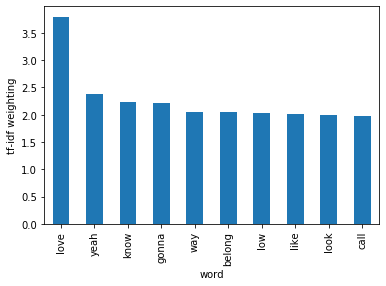

In [9]:
ax = rank1.plot(kind='bar')
ax.set_xlabel("word")
ax.set_ylabel("tf-idf weighting")

Text(0, 0.5, 'tf-idf weighting')

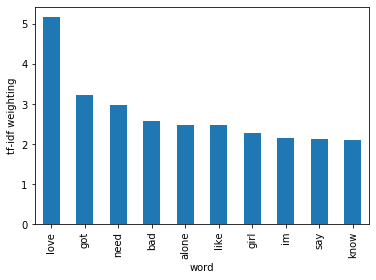

In [10]:
ax = rank2.plot(kind='bar')
ax.set_xlabel("word")
ax.set_ylabel("tf-idf weighting")

As shown by the above bar charts, there seems to be very little correlation between rank and words. This is because a lot of the words among the ranks are shared and there are no words that are representative of a single rank. Hence, we decided to change our hypothesis to predict another metric.

### Correlation Between TF-IDF and YEAR

The next metric we decided to analyse was the correlation between words and years.<br>
We cleaned the data by binning the Years by songs on the charts before the 2000's and songs on the charts after the 2000's.

In [11]:
data = data.drop(['Song','Lyrics', 'Artist', 'Rank'], axis=1)
def year_bin_rank(Year):
    if Year <2000:
        return 1
    elif Year >= 2000:
        return 2
data['Year'] = data['Year'].apply(year_bin_rank)

The bins were pretty uneven, so we decided to decrease the no. of songs in bin 1 by dropping a few.

Text(0, 0.5, 'total per bin')

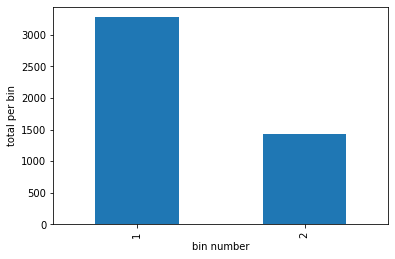

In [12]:
ax = data['Year'].value_counts().plot(kind='bar')
ax.set_xlabel("bin number")
ax.set_ylabel("total per bin")

In [13]:
data['Year'].value_counts()

1    3276
2    1434
Name: Year, dtype: int64

In [14]:
data = data.sort_values('Year', ascending=False).iloc[:(1434*2)].sort_index().reset_index(drop=True)

In [15]:
data['Year'].value_counts()

1    1434
2    1434
Name: Year, dtype: int64

Next, we decided to take a look at the correlation between Year and the words in each song. We apply a sum on the groupby of Year and took a look at the top 10 words for each binned year.

In [16]:
year1 = data.groupby('Year').sum().loc[1].sort_values(ascending=False).iloc[:10]
year2 = data.groupby('Year').sum().loc[2].sort_values(ascending=False).iloc[:10]

Text(0, 0.5, 'tf-idf weighting')

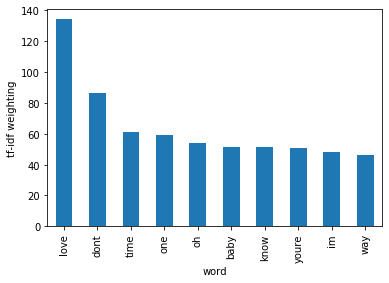

In [17]:
ax = year1.plot(kind='bar')
ax.set_xlabel("word")
ax.set_ylabel("tf-idf weighting")

Text(0, 0.5, 'tf-idf weighting')

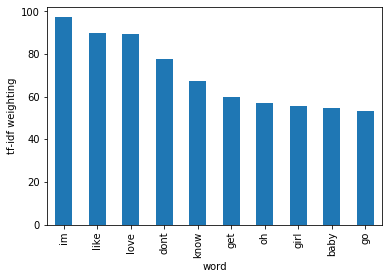

In [18]:
ax = year2.plot(kind='bar')
ax.set_xlabel("word")
ax.set_ylabel("tf-idf weighting")

The bar charts show that there seems to be some correlation between years and words. There are certain words that correlate strongly to a particular binned year.
<br>
<br>
Hence, we decided to use year as our metric for prediction.

# Data Analysis & Results

For our analysis we split the dataset into train and test sets to see if we could predict song popularity based on lyrics. The training set contains 70% of the dataset and is randomly selected. The test set contains the rest of the 30% of the dataset.

In [19]:
X = data.drop('Year', axis=1).values
y = data['Year'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Next, we passed our dataset that are to be trained and tested into three different classification models.
<br>
<br>
The first model we implemented was the naïve bayes model. This model calculates the conditional probability of the TF-IDF of a word with respect to the labels from its training data. It then uses the features from the test data to find the maximum probability conditional on each label. The label with maximum conditional probability is the one returned as the predicted label. 
<br>
<br>
<b>Reference:</b> https://scikit-learn.org/stable/modules/naive_bayes.html

In [20]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
clf.score(X_test, y_test)

0.8802706923477356


0.737064413938754

This model did pretty well in predicting the data; both the training and test accuracy scores were pretty high.
<br>
<br>
The second model, RandomForestClassifier uses multiple decision trees and average to fit and predict data. 
<br>
<br>
<b>Reference:</b> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [21]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
rf.score(X_test, y_test)

0.9906298802706923


0.7001055966209081

This model does not perform as well as the naïve bayes model as shown by the test accuracy. This is probably because the randomforestclassifier overfits training data. Hence, it is unable to accurately classify the test data.

The last model, Knearest Neighbors, uses distances between each row/feature/point/songs TF-IDF to predict labels. First, the model is supplied a training dataset with labels. Next, the model is given test data, which it uses to find the distance between each point of the test data and each point of the training data to find the point that has the least distance between each other. It then returns the label of the point in the training dataset as the point of that particular test point.
<br>
<br>
<b>Reference:</b> https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [22]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
clf.score(X_test, y_test)

0.5960437272254034


0.5163674762407603

This model did not do very well in training or testing. This is probably because a lot of the words in songs are very similar. Hence, it is hard to avoid or ignore the words that are very similar in the songs. 

Based on these models and their results, we realized that certain words in lyrics alone are not enough to predict song popularity.

# Ethics & Privacy

Throughout our process, we used only public information in regards to public data of song lyrics and ranking on music charts throughout the years.  

Our project did not harm the music industry in any way and we ensured all the steps of our project were handled privately and not used in any destructive manner. 

We ensured that we have permission for any dataset we used for this project and made sure to minimalize biases from our data by taking into account the make-up of our dataset.  

For example, we realized as we were looking at our dataset that a majority of the artist T-Pain's lyrics were not included in the lyrics feature, as well as lyrics of other artists such as Soulja Boy, Linkin Park, and many more, influencing the bias of our dataset.  Similarly, some of the lyrics being in Spanish also influenced bias in that words that may be used frequently if the song were to be translated were discounted because of the language barrier.  

These discrepancies ultimately influence sampling bias in terms of the lack of consistent collection of data for certain artists and songs.  In order to avoid this sampling bias, all lyrics would need to be included from the same lyrics source, in the same language, for every song included in the dataset.

# Conclusion & Discussion

### Discussing our Project

The initial goal when we undertook this project was to determine whether or not commonly used words in music can influence the popularity of a song. One of the driving reasons behind us choosing this topic was that music is universal, and it is something that can be shared and enjoyed by many people. 

Also, our group members love music, and we were enthusiastic to explore some datasets that explored data related to music as well. We also referred to other projects with similar goals, such as a project done at Stanford to predict a song’s “hotness” based on lyrics and other metrics, and another study done at UPenn that gives some insight as to how lyrics may influence song popularity. These findings inspired us to work on our own project concerned with musical data. We hypothesize that some of the most common words used in popular songs contribute to their popularity. We wanted to show that if we see certain words that come up repeatedly in the most popular songs, we can attribute the popularity of songs to those certain words. 

### Summarizing our Data and Question

We wanted to use music data that we thought would best answer our research question. We used a dataset that contained all Billboard Top 100 songs from the years 1964 to the year 2015, including each song’s title, chart position, year charted, lyrics, and lyrics source. We looked at the lyrics in the dataset, with a focus on pop songs from 2000 to 2015. From this data we wanted to figure out what words are used in the top Billboard songs, since they are the songs that generate the most revenue. We wanted to research which words contribute to the highest revenue generation in the pop genre in our specified time period. 

### Summarizing our Results and Conclusion

We wanted this project to be a good indicator of what our society likes to see in their music by looking at which words are more trendy in pop culture. However, we concluded through our analysis that words aren’t a very good indicator of the predicted popularity of songs; showing that our hypothesis was incorrect. As such, throughout our process, we realized that it was more likely that our hypothesis should have in fact been that there are other features, or perhaps a combination, that affect song popularity.  We then tried to see if words can better predict other variables and finally we came up with a new hypothesis that words better predict whether a song belongs before or after the 21st century. Through our analysis we saw that certain words appear more in songs that were released after 2000, while there are certain other words which were used more commonly in songs from the previous era.

### Limitations to our Project

In relation to our code, we encountered several difficulties that added limitations to our study.  These include our bin size impacting the accuracy of our predictions, dealing with Spanish words which were out of the scope of the project, dealing with missing values in terms of missing lyrics for certain songs as well as instrumental songs, and  dealing with expressions used in lyrics that can't be classified as specific words. Additionally, we had to account for some numbers in the dataset that were spelled out, making them have less impact on the results than they should have.  Lastly, lyrics in the dataset were obtained from a number of different lyric sources, all of which have different styles in terms of how different words are spelled based on how they are heard.

### Impacts of Work on Society

Even though this project doesn’t have a big impact on society, and is mainly done to satisfy our curiosity, we wanted this project to be a good indicator of what kind of words our music industry gravitates towards. We thought it could be fascinating to be able to use this predictor tool to better understand what the future of music may look like!

Instead we figured out how words can predict whether a song belongs to our current era or a previous one. This can explain the popularity of certain words that we are more familiar with nowadays compared to words that were more used in the past.

# Team Contributions

Prior to beginning our project, it was really important to each of us that we all work together in person/on Zoom to understand the entirety of our project and the code behind each of the steps we were taking.  As such, we all worked together on each component, which although was more time consuming, ensured we all had full understanding of our project from start to end.  

In terms of compiling our final project, Yubi and Shinu worked together on analysis and EDA while Shadman, Shabab and Ria worked on conclusion and discussion.